Mohammed elidrissi laoukili
* subjet  : video analysis

In [16]:
# Install Required Libraries (Output: install logs)
!pip install mtcnn opencv-contrib-python scikit-image

In [17]:
# ===================================================================
# TP3 - ACTIVITÉ 1: Face Recognition with MTCNN + LBP + SVM
# According to TP specifications
# ===================================================================

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logs
import warnings
warnings.filterwarnings('ignore')

# Then import your ML libraries
import cv2
import numpy as np
from mtcnn import MTCNN
from skimage import feature
from sklearn import svm
import joblib
import matplotlib.pyplot as plt

# Configuration
DATASET_PATH = "/kaggle/input/pins-face-recognition/105_classes_pins_dataset"
NUM_PEOPLE = 15
NUM_IMAGES_PER_PERSON = 10

print("=" * 60)
print("TP3 - FACE RECOGNITION: MTCNN + LBP + SVM")
print("=" * 60)

TP3 - FACE RECOGNITION: MTCNN + LBP + SVM


In [18]:
# ===================================================================
# FONCTION DE DÉTECTION DE VISAGES (from TP)
# ===================================================================
def detect_faces(image):
    """Detect faces using MTCNN"""
    detector = MTCNN()
    faces = detector.detect_faces(image)
    return faces
print("DONE!")

DONE!


In [19]:
# ===================================================================
# FONCTION POUR EXTRAIRE DES CARACTÉRISTIQUES LBP (from TP)
# ===================================================================
def extract_lbp(image):
    """Extract LBP features from face image"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = feature.local_binary_pattern(gray, P=8, R=1, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)  # Add epsilon to avoid division by zero
    return hist
print("DONE!")


DONE!


In [20]:
# ===================================================================
# FONCTION POUR ENTRAÎNER LE MODÈLE SVM (from TP)
# ===================================================================
def train_svm(features, labels):
    """Train SVM model with linear kernel"""
    model = svm.SVC(kernel='linear', probability=True)
    model.fit(features, labels)
    return model
print("DONE!")


DONE!


In [21]:
# ===================================================================
# CHARGER OU ENTRAÎNER LE MODÈLE SVM (from TP)
# ===================================================================
def load_or_train_svm(training_data, training_labels):
    """Load existing model or train new one"""
    try:
        model = joblib.load("face_recognition_model.pkl")
        print("✓ Existing SVM model loaded from file")
    except FileNotFoundError:
        print("✗ Model not found. Training new SVM model...")
        model = train_svm(training_data, training_labels)
        joblib.dump(model, "face_recognition_model.pkl")
        print("✓ New SVM model trained and saved")
    return model

print("DONE!")


DONE!


In [22]:
# ===================================================================
# PRÉPARER LES DONNÉES D'ENTRAÎNEMENT
# ===================================================================

print("\n" + "=" * 60)
print("EXTRACTING TRAINING DATA FROM KAGGLE DATASET")
print("=" * 60)

features = []
labels = []
label_map = {}
current_label = 0

detector = MTCNN()
people_list = sorted(os.listdir(DATASET_PATH))[:NUM_PEOPLE]

for person_name in people_list:
    person_dir = os.path.join(DATASET_PATH, person_name)
    
    if not os.path.isdir(person_dir):
        continue
    
    label_map[current_label] = person_name
    person_faces = 0
    
    for img_name in os.listdir(person_dir)[:NUM_IMAGES_PER_PERSON]:
        img_path = os.path.join(person_dir, img_name)
        
        try:
            # Lire l'image
            image = cv2.imread(img_path)
            if image is None:
                continue
            
            # Convertir en RGB pour MTCNN
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Détecter les visages avec MTCNN
            faces_detected = detect_faces(image_rgb)
            
            if faces_detected and len(faces_detected) > 0:
                # Prendre le premier visage détecté
                face_data = faces_detected[0]
                x, y, width, height = face_data['box']
                
                # S'assurer que les coordonnées sont valides
                x, y = max(0, x), max(0, y)
                detected_face = image[y:y+height, x:x+width]
                
                if detected_face.size == 0:
                    continue
                
                # Redimensionner pour uniformité
                detected_face = cv2.resize(detected_face, (100, 100))
                
                # Extraire LBP pour le visage détecté
                lbp_features = extract_lbp(detected_face)
                
                features.append(lbp_features)
                labels.append(current_label)
                person_faces += 1
        
        except Exception as e:
            continue
    
    if person_faces > 0:
        print(f"Label {current_label}: {person_name:30s} → {person_faces} faces")
        current_label += 1

print(f"\n{'=' * 60}")
print(f"TOTAL TRAINING SAMPLES: {len(features)}")
print(f"TOTAL CLASSES: {len(set(labels))}")
print(f"{'=' * 60}\n")


EXTRACTING TRAINING DATA FROM KAGGLE DATASET
Label 0: pins_Adriana Lima              → 10 faces
Label 1: pins_Alex Lawther              → 10 faces
Label 2: pins_Alexandra Daddario        → 10 faces
Label 3: pins_Alvaro Morte              → 10 faces
Label 4: pins_Amanda Crew               → 10 faces
Label 5: pins_Andy Samberg              → 10 faces
Label 6: pins_Anne Hathaway             → 10 faces
Label 7: pins_Anthony Mackie            → 10 faces
Label 8: pins_Avril Lavigne             → 10 faces
Label 9: pins_Ben Affleck               → 10 faces
Label 10: pins_Bill Gates                → 10 faces
Label 11: pins_Bobby Morley              → 10 faces
Label 12: pins_Brenton Thwaites          → 10 faces
Label 13: pins_Brian J. Smith            → 10 faces
Label 14: pins_Brie Larson               → 10 faces

TOTAL TRAINING SAMPLES: 150
TOTAL CLASSES: 15



In [23]:
# ===================================================================
# ENTRAÎNER LE MODÈLE SVM
# ===================================================================

if len(features) < 2:
    print("✗ Not enough training data!")
    exit()

# Convertir en arrays numpy
features = np.array(features)
labels = np.array(labels)

# Charger ou entraîner le modèle SVM
model = load_or_train_svm(features, labels)

✓ Existing SVM model loaded from file



TESTING MODEL ON TRAINING DATA
Collected 5 test samples

Test 1: True=pins_Adriana Lima    | Pred=pins_Alvaro Morte    | Conf=  6.9% | ✗
Test 2: True=pins_Alex Lawther    | Pred=pins_Alvaro Morte    | Conf=  6.8% | ✗
Test 3: True=pins_Alexandra Dadda | Pred=pins_Alexandra Dadda | Conf=  7.2% | ✓
Test 4: True=pins_Alvaro Morte    | Pred=pins_Alvaro Morte    | Conf=  6.9% | ✓
Test 5: True=pins_Amanda Crew     | Pred=pins_Alexandra Dadda | Conf=  7.4% | ✗


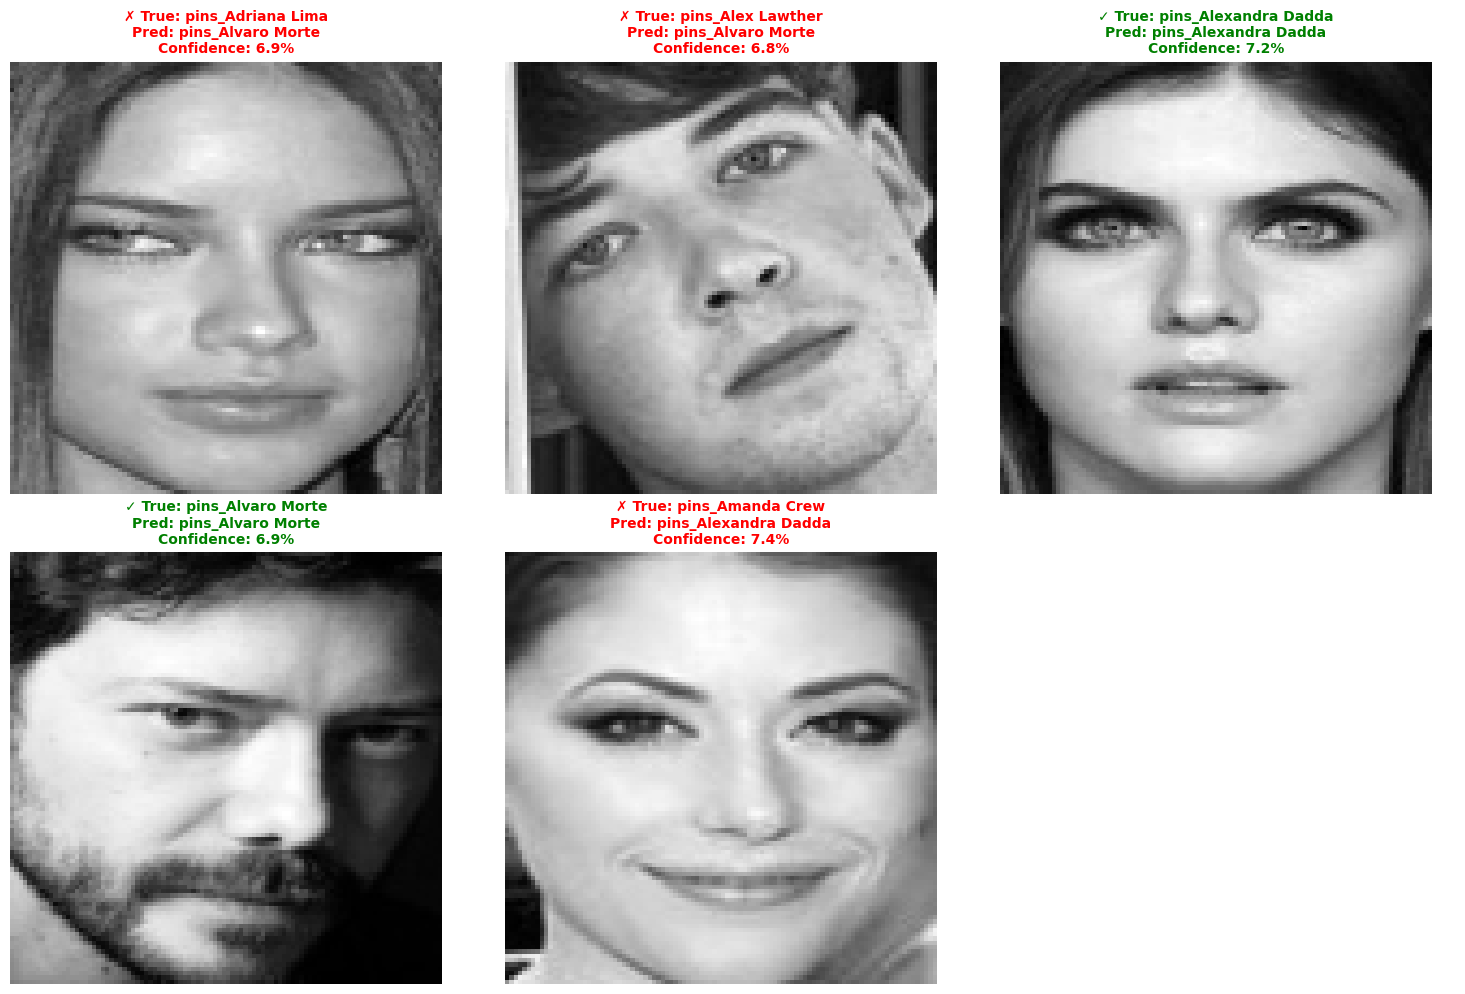


Test Accuracy: 2/5 = 40.0%


In [24]:
# ===================================================================
# TESTER LE MODÈLE - FIXED VERSION WITH REAL IMAGES
# ===================================================================

print("\n" + "=" * 60)
print("TESTING MODEL ON TRAINING DATA")
print("=" * 60)

# We need to store the actual face images during training
# Let's reload a few samples to display them properly

# Prepare to collect test samples with their actual images
test_samples = []
sample_count = 0
target_samples = 5

# Reload some images to display
for person_name in people_list:
    if sample_count >= target_samples:
        break
        
    person_dir = os.path.join(DATASET_PATH, person_name)
    
    if not os.path.isdir(person_dir):
        continue
    
    for img_name in os.listdir(person_dir)[:NUM_IMAGES_PER_PERSON]:
        if sample_count >= target_samples:
            break
            
        img_path = os.path.join(person_dir, img_name)
        
        try:
            image = cv2.imread(img_path)
            if image is None:
                continue
            
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            faces_detected = detect_faces(image_rgb)
            
            if faces_detected and len(faces_detected) > 0:
                face_data = faces_detected[0]
                x, y, width, height = face_data['box']
                
                x, y = max(0, x), max(0, y)
                detected_face = image[y:y+height, x:x+width]
                
                if detected_face.size == 0:
                    continue
                
                detected_face_resized = cv2.resize(detected_face, (100, 100))
                detected_face_gray = cv2.cvtColor(detected_face_resized, cv2.COLOR_BGR2GRAY)
                
                # Extract LBP features
                lbp_features = extract_lbp(detected_face_resized)
                
                # Find the label for this person
                person_label = None
                for lbl, name in label_map.items():
                    if name == person_name:
                        person_label = lbl
                        break
                
                if person_label is not None:
                    test_samples.append({
                        'image': detected_face_gray,
                        'features': lbp_features,
                        'true_label': person_label,
                        'person_name': person_name
                    })
                    sample_count += 1
                    break
        
        except Exception as e:
            continue

print(f"Collected {len(test_samples)} test samples\n")

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

correct_predictions = 0
total_predictions = 0

for idx, sample in enumerate(test_samples):
    if idx >= 5:  # Only show 5 samples
        break
    
    # Get sample data
    display_img = sample['image']
    test_features = sample['features'].reshape(1, -1)
    true_label = sample['true_label']
    true_name = sample['person_name']
    
    # Prédiction avec le modèle SVM
    prediction = model.predict(test_features)[0]
    probabilities = model.predict_proba(test_features)[0]
    confidence = max(probabilities) * 100
    
    # Get predicted name
    pred_name = label_map.get(prediction, "Unknown")
    
    # Display the actual face image
    axes[idx].imshow(display_img, cmap="gray")
    
    # Determine if correct
    correct = "✓" if prediction == true_label else "✗"
    color = "green" if prediction == true_label else "red"
    
    # Create title
    title = f"{correct} True: {true_name[:20]}\n"
    title += f"Pred: {pred_name[:20]}\n"
    title += f"Confidence: {confidence:.1f}%"
    
    axes[idx].set_title(title, color=color, fontsize=10, weight='bold')
    axes[idx].axis("off")
    
    if prediction == true_label:
        correct_predictions += 1
    total_predictions += 1
    
    print(f"Test {idx+1}: True={true_name[:20]:20s} | "
          f"Pred={pred_name[:20]:20s} | "
          f"Conf={confidence:5.1f}% | {correct}")

# Hide unused subplot
axes[5].axis("off")

plt.tight_layout()
plt.savefig('svm_recognition_results.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n{'=' * 60}")
print(f"Test Accuracy: {correct_predictions}/{total_predictions} = {(correct_predictions/total_predictions*100):.1f}%")
print(f"{'=' * 60}")

In [25]:
# ===================================================================
# ÉVALUATION COMPLÈTE DU MODÈLE
# ===================================================================

print(f"\n{'=' * 60}")
print("MODEL EVALUATION")
print("=" * 60)

# Prédire sur toutes les données d'entraînement
all_predictions = model.predict(features)
accuracy = (all_predictions == labels).sum() / len(labels) * 100

print(f"Training Accuracy: {accuracy:.2f}%")
print(f"Total Samples: {len(features)}")
print(f"Correct Predictions: {(all_predictions == labels).sum()}")
print(f"Incorrect Predictions: {(all_predictions != labels).sum()}")
print("=" * 60)


MODEL EVALUATION
Training Accuracy: 18.00%
Total Samples: 150
Correct Predictions: 27
Incorrect Predictions: 123



VIDEO PROCESSING - FACE DETECTION & RECOGNITION
✓ Input video found: /kaggle/input/sample-video-tp3-actor/tp3-input_video_main.mp4

Video Properties:
  - Resolution: 1280x720
  - FPS: 25
  - Total Frames: 460
  - Duration: 18.40 seconds

✓ Output video will be saved to: /kaggle/working/output_video.mp4

Processing video...
Initializing MTCNN detector...
✓ Detector ready

Processing frame 30/460 (6.5%)
Processing frame 60/460 (13.0%)
Processing frame 90/460 (19.6%)
Processing frame 120/460 (26.1%)
Processing frame 150/460 (32.6%)
Processing frame 180/460 (39.1%)
Processing frame 210/460 (45.7%)
Processing frame 240/460 (52.2%)
Processing frame 270/460 (58.7%)
Processing frame 300/460 (65.2%)
Processing frame 330/460 (71.7%)
Processing frame 360/460 (78.3%)
Processing frame 390/460 (84.8%)
Processing frame 420/460 (91.3%)
Processing frame 450/460 (97.8%)
✓ Video processing complete!
  - Frames processed: 457
  - Total faces detected: 478
  - Average faces per frame: 1.05

✓ Output saved


✓ Video displayed above!

Extracting sample frames for preview...


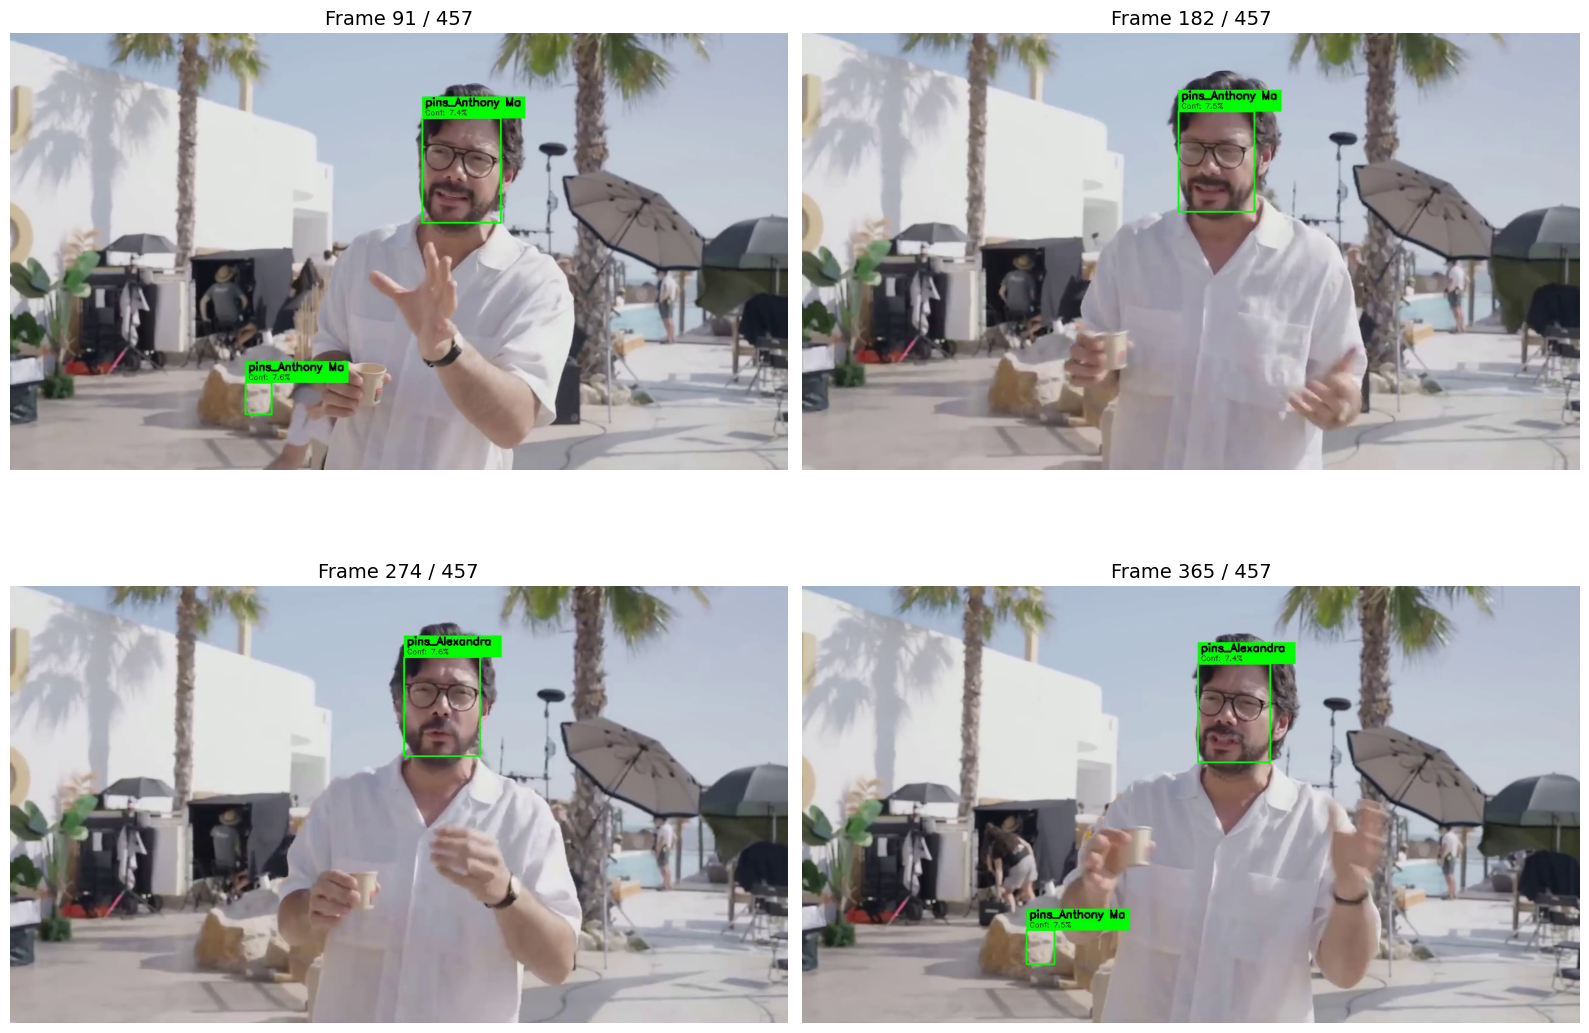

✓ Sample frames displayed above
✓ Sample frames saved to: /kaggle/working/sample_frames.png

VIDEO PROCESSING COMPLETE!

Output files:
  1. Processed video: /kaggle/working/output_video.mp4
  2. Display video (H264): /kaggle/working/output_video_display.mp4
  3. Sample frames: /kaggle/working/sample_frames.png
  4. Recognition results: svm_recognition_results.png

✓ All files saved to /kaggle/working/


In [26]:
# ===================================================================
# VIDEO PROCESSING - OPTIMIZED VERSION
# ===================================================================

import cv2
import numpy as np
from IPython.display import Video, display
import os

print("\n" + "=" * 60)
print("VIDEO PROCESSING - FACE DETECTION & RECOGNITION")
print("=" * 60)

# Configuration
INPUT_VIDEO = "/kaggle/input/sample-video-tp3-actor/tp3-input_video_main.mp4"
OUTPUT_VIDEO = "/kaggle/working/output_video.mp4"
OUTPUT_VIDEO_DISPLAY = "/kaggle/working/output_video_display.mp4"

# Check if input video exists
if not os.path.exists(INPUT_VIDEO):
    print(f"✗ Video not found at: {INPUT_VIDEO}")
    print("Please verify the path to your video file.")
else:
    print(f"✓ Input video found: {INPUT_VIDEO}")
    
    # Open video capture
    cap = cv2.VideoCapture(INPUT_VIDEO)
    
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"\nVideo Properties:")
    print(f"  - Resolution: {width}x{height}")
    print(f"  - FPS: {fps}")
    print(f"  - Total Frames: {total_frames}")
    print(f"  - Duration: {total_frames/fps:.2f} seconds")
    
    # Define codec and create VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(OUTPUT_VIDEO, fourcc, fps, (width, height))
    
    print(f"\n✓ Output video will be saved to: {OUTPUT_VIDEO}")
    print("\nProcessing video...")
    print("=" * 60)
    
    frame_count = 0
    faces_detected_total = 0
    
    # ⚡ CRITICAL FIX: Initialize MTCNN detector ONCE outside the loop
    print("Initializing MTCNN detector...")
    detector_video = MTCNN()
    print("✓ Detector ready\n")
    
    while True:
        ret, frame = cap.read()
        
        if not ret:
            break
        
        frame_count += 1
        
        # Show progress every 30 frames
        if frame_count % 30 == 0:
            progress = (frame_count / total_frames) * 100
            print(f"Processing frame {frame_count}/{total_frames} ({progress:.1f}%)")
        
        try:
            # ⚡ USE PRE-INITIALIZED DETECTOR (not detect_faces function)
            faces = detector_video.detect_faces(frame)
            
            if faces:
                faces_detected_total += len(faces)
            
            for face in faces:
                x, y, width_box, height_box = face['box']
                
                # Ensure coordinates are valid
                x = max(0, x)
                y = max(0, y)
                width_box = min(width_box, frame.shape[1] - x)
                height_box = min(height_box, frame.shape[0] - y)
                
                # Skip invalid boxes
                if width_box <= 0 or height_box <= 0:
                    continue
                
                # Extract detected face
                detected_face = frame[y:y+height_box, x:x+width_box]
                
                if detected_face.size == 0:
                    continue
                
                # Resize face for consistent processing
                detected_face_resized = cv2.resize(detected_face, (100, 100))
                
                # Extract LBP features
                lbp_features = extract_lbp(detected_face_resized)
                
                # Predict with SVM model
                prediction = model.predict([lbp_features])[0]
                probabilities = model.predict_proba([lbp_features])[0]
                confidence = max(probabilities) * 100
                
                # Get predicted person name
                person_name = label_map.get(prediction, "Unknown")
                
                # Draw rectangle around face (green)
                cv2.rectangle(frame, (x, y), (x + width_box, y + height_box), (0, 255, 0), 2)
                
                # Prepare text with name and confidence
                text = f"{person_name[:15]}"
                conf_text = f"Conf: {confidence:.1f}%"
                
                # Draw background rectangles for text
                (text_width, text_height), _ = cv2.getTextSize(
                    text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2
                )
                cv2.rectangle(frame, (x, y - 35), (x + text_width + 10, y), (0, 255, 0), -1)
                
                # Draw text (black on green background)
                cv2.putText(frame, text, (x + 5, y - 20), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
                cv2.putText(frame, conf_text, (x + 5, y - 5), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 0), 1)
        
        except Exception as e:
            # If error occurs, just save frame without annotations
            if frame_count % 100 == 0:  # Only print occasional errors
                print(f"Warning: Error processing frame {frame_count}: {str(e)}")
        
        # Write frame to output video
        out.write(frame)
    
    # Release everything
    cap.release()
    out.release()
    
    print("=" * 60)
    print(f"✓ Video processing complete!")
    print(f"  - Frames processed: {frame_count}")
    print(f"  - Total faces detected: {faces_detected_total}")
    if frame_count > 0:
        print(f"  - Average faces per frame: {faces_detected_total/frame_count:.2f}")
    print(f"\n✓ Output saved to: {OUTPUT_VIDEO}")
    
    # ===================================================================
    # CONVERT TO H264 FOR BETTER COMPATIBILITY
    # ===================================================================
    
    print("\n" + "=" * 60)
    print("Converting to H264 for better playback...")
    
    try:
        import subprocess
        
        # Convert to H264 codec for better browser compatibility
        cmd = [
            'ffmpeg', '-y', '-i', OUTPUT_VIDEO,
            '-vcodec', 'libx264', '-acodec', 'aac',
            '-strict', 'experimental', '-b:a', '192k',
            OUTPUT_VIDEO_DISPLAY
        ]
        
        result = subprocess.run(cmd, capture_output=True, text=True)
        
        if result.returncode == 0:
            print(f"✓ Converted video saved to: {OUTPUT_VIDEO_DISPLAY}")
            display_path = OUTPUT_VIDEO_DISPLAY
        else:
            print("⚠ Conversion failed, using original format")
            display_path = OUTPUT_VIDEO
    
    except:
        print("⚠ ffmpeg not available, using original format")
        display_path = OUTPUT_VIDEO
    
    # ===================================================================
    # DISPLAY VIDEO IN NOTEBOOK
    # ===================================================================
    
    print("\n" + "=" * 60)
    print("Displaying output video in notebook...")
    print("=" * 60)
    
    try:
        display(Video(display_path, width=800, embed=True))
        print("\n✓ Video displayed above!")
    except Exception as e:
        print(f"⚠ Could not display video: {str(e)}")
        print(f"You can download it from: {display_path}")
    
    # ===================================================================
    # EXTRACT SAMPLE FRAMES FOR PREVIEW
    # ===================================================================
    
    print("\n" + "=" * 60)
    print("Extracting sample frames for preview...")
    print("=" * 60)
    
    cap = cv2.VideoCapture(display_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Extract 4 evenly spaced frames
    sample_frames = []
    frame_indices = [total//5, 2*total//5, 3*total//5, 4*total//5]
    
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            # Convert BGR to RGB for matplotlib
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            sample_frames.append(frame_rgb)
    
    cap.release()
    
    # Display sample frames
    if sample_frames:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        
        for idx, frame in enumerate(sample_frames):
            axes[idx].imshow(frame)
            axes[idx].set_title(f"Frame {frame_indices[idx]} / {total}", fontsize=14)
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.savefig('/kaggle/working/sample_frames.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print("✓ Sample frames displayed above")
        print("✓ Sample frames saved to: /kaggle/working/sample_frames.png")
    
    print("\n" + "=" * 60)
    print("VIDEO PROCESSING COMPLETE!")
    print("=" * 60)
    print("\nOutput files:")
    print(f"  1. Processed video: {OUTPUT_VIDEO}")
    print(f"  2. Display video (H264): {OUTPUT_VIDEO_DISPLAY}")
    print(f"  3. Sample frames: /kaggle/working/sample_frames.png")
    print(f"  4. Recognition results: svm_recognition_results.png")
    print("\n✓ All files saved to /kaggle/working/")
    print("=" * 60)